<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Pset 4: Problems Using Numerical Simulation Part II</h1>


<a name='section_4_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.0 Overview</h2>


<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_5">P4.5 Galaxy Rotation Curves</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_5">P4.5 Problems</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_4_6">P4.6 Training a NN to Find Tau Leptons</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#problems_4_6">P4.6 Problems</a></td>
    </tr>    
</table>



<h3>Learning Objectives</h3>

In this Pset, we will simulate a galaxy and, from this simuilation, we will then compute rotation curves. We will also explore NN modeling of Tau


<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [1]:
#>>>RUN: P4.0-runcell00

#install the following if you have note done so:

!pip install imageio
!pip3 install torch torchvision torchaudio
!pip install lmfit
!pip install uproot


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
#>>>RUN: P4.0-runcell01

import itertools
from IPython.display import HTML
from scipy.integrate import odeint
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import imageio
from IPython.display import Image
import random

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.

In [3]:
#>>>RUN: P4.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<!--start-block-->
<a name='section_4_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.5 Galaxy Rotation Curves

| [Top](#section_4_0) | [Previous Section](#section_4_0) | [Problems](#problems_4_5) | [Next Section](#section_4_6) | 

<h3>Overview</h3>

In this problem, we are going to make a simulation of a galaxy, from this simuilation, we will then compute rotation curves. The we will modify the simulation, adding two populations, visible matter, and dark matter. Then we will see how we can emulate the behavior of rotation curves.

Lastly, we will investigate how to bring this to scale.

In [4]:
import imageio
from PIL import Image
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import csv

#Units
Gc=39.478 #AU^3/yr^2/Msun
re=1.0#AU
ve=2*np.pi*re#2pir/yr
Gmod=Gc/re**2

<h3> Basic Setup </h3>

Lets start by seeing how a galaxy forms. To do that, lets randomly place in a uniform distribution of stars, and then evolve it under forces of gravity. For the first part of this problem, we will use the parallelized part of the star evolution, as oppose to the tree structure.  

<a name='problems_4_5'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.1</span>

In the code below, add the force equations and computation of $\Delta r^2_{ij}=\Delta x_{ij}^2 + \Delta y_{ij}^2 + \epsilon^2$ matrix that builds on the $\Delta r$ computation. Be sure to add the softening term $\epsilon$.

Then run the subsequent code after this problem to create the visualization.


In [7]:
x= np.array([[0.,0.],[1.,0.],[0.,1.]])[:,1:2]
x.T-x

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [-1., -1.,  0.]])

In [34]:
#>>>PROBLEM: P4.5.1

#this function computes the force and potential energy of the system
def forcefunction_base(iR,iMass,iSoften):
    xpos=iR[:,0:1]
    ypos=iR[:,1:2]
    dx = xpos.T - xpos
    dy = ypos.T - ypos
    dr2  = dx**2 + dy**2 + iSoften**2
    dr1  = dr2**(-0.5)
    dr2[dr2>0] = dr2[dr2>0]**(-1.5)
    ax   = Gmod * (dx*dr2) @ iMass
    ay   = Gmod * (dy*dr2) @ iMass
    a = np.hstack((ax,ay))
    pot = -1.*Gmod * dr1 @ iMass
    return a,pot

In [35]:
forcefunction_base(
    iR=np.array([[0.,0.],[1.,0.],[0.,1.]]),
    iMass=np.array([1.,2.,3.]),
    iSoften=0.1
)

(array([ 77.78629346, -80.45379482,  27.70709873, 116.67944018,
         41.56064809, -66.60024546]),
 array([ -591.19039098,  -912.37898086, -1279.31334664]))

<h3>Define the Visualization</h3>

Having completed the code for `forcefunction`, run the cell below to define our visualization.

In [36]:
#>>>RUN

###Visualiztion code
def makePlot(nbody,coords,ax,fig,images,ymin=-2,ymax=2,xmin=-2,xmax=2):
    # plot and show learning process
    plt.cla()
    ax.set_xlabel('x(AU)', fontsize=24)
    ax.set_ylabel('y(AU)', fontsize=24)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    for body in range(nbody):
        ax.plot(np.flip(coords[body][:,0]),np.flip(coords[body][:,1]), 'o-',color = '#d2eeff',markevery=10000, markerfacecolor = '#0077BE',lw=2)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)


def animate(coords,iN=2,ymin=-10,ymax=10,xmin=-10,xmax=10,stepsize=50):
    images = []
    fig, ax = plt.subplots(figsize=(12,7))
    for step in range(len(coords[0])-110):
        if step % stepsize == 0:
            makePlot(iN,coords[:,step:step+100],ax,fig,images,ymin=ymin,ymax=ymax,xmin=xmin,xmax=xmax)
    return images


class AllStars:
    def __init__(self,iX,iV,iM,ibase=True,isoften=1e-2):
        self.rpos = iX
        self.v    = iV
        self.mass = iM
        self.n    = len(iX)
        self.posh   = np.array([])
        self.velh   = np.array([])
        self.enh    = np.array([])
        self.nsteps = 0
        self.soften = isoften
        self.base   = ibase

    def force(self): #take in arrays of everything
        if self.base:
            self.a,self.pot = forcefunction_base(self.rpos,self.mass,self.soften)
        else:
            self.a,self.pot = forcefunction(self.rpos,self.mass,self.soften)

    def firststep(self,dt):
        self.v    = self.v   +0.5*dt*self.a
        self.rpos = self.rpos+dt*self.v

    def step(self,dt):
        self.v    = self.v   +dt*self.a
        self.rpos = self.rpos+dt*self.v

    def store(self):
        lXs = self.rpos
        self.posh = np.append(self.posh,lXs)
        lVs = self.v
        self.velh = np.append(self.velh,lVs)
        lV2 = np.reshape((lVs[:,0]**2+lVs[:,1]**2),(self.n,1))
        lEn = 0.5*self.mass*lV2 + self.mass *self.pot
        self.enh  = np.append(self.enh,lEn)

    def points(self):
        return self.rpos

    def history(self):
        return np.reshape(self.posh,(self.nsteps,self.n,2))

    def velhistory(self):
        return np.reshape(self.velh,(self.nsteps,self.n,2))

    def enhistory(self):
        return np.reshape(self.enh,(self.nsteps,self.n))

    def allsteps(self,insteps=5000,dt=0.001):
        nsteps=insteps
        self.nsteps+=nsteps
        self.force()
        self.firststep(dt)
        for t in range(nsteps):
            self.force()
            self.step(dt)
            self.store()
        return self.points()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.2</span>

Now lets check if this code makes sense. Perform a 2-body simulation for a circular orbit of a binary star, each having a solar mass and radius of 1 Au. Note that,

$$\frac{\mu v^2}{r } = \frac{GM_{1}M_{2}}{r^2}$$

What is the timestep `dt` where the simulation breaks down? Enter a number.

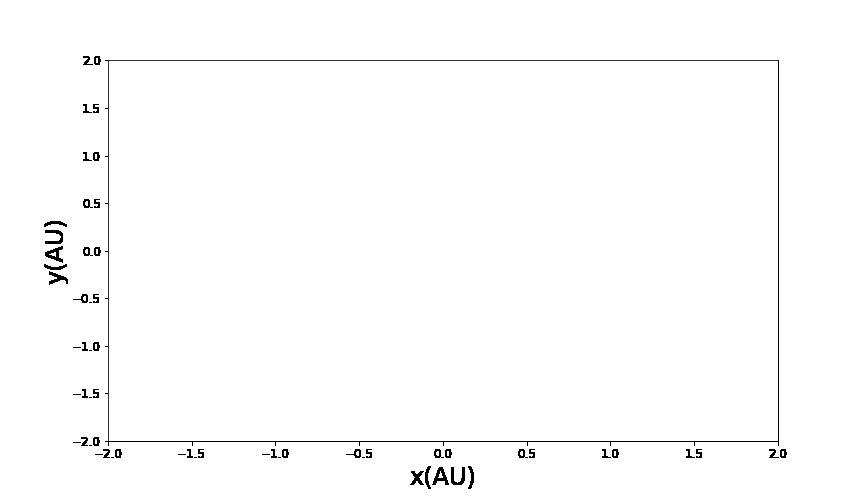

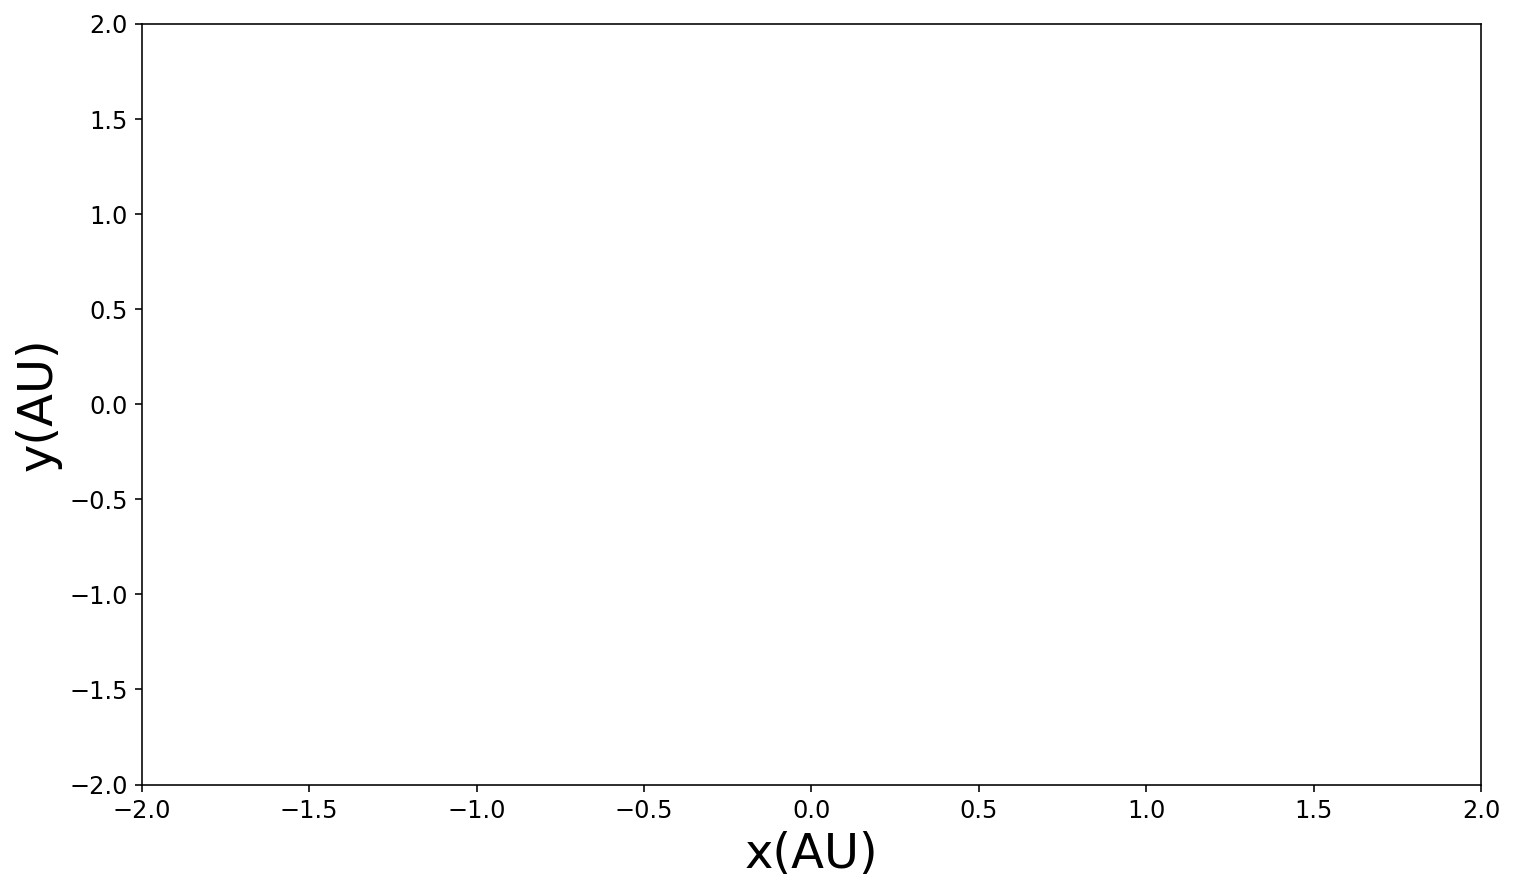

In [57]:
#>>>PROBLEM: P4.5.2

np.random.seed(1234)
nStar=2
X = np.zeros((nStar, 2))
V = np.zeros((nStar, 2))
M = np.ones((nStar,1))

vcircle = np.sqrt(Gmod*1/2)

X[0,0] =  1
X[1,0] = -1
V[0,1] =  vcircle*0.5
V[1,1] = -vcircle*0.5

allStar = AllStars(X,V,M)
Xout=allStar.allsteps(insteps=5000,dt=1e1) ###for what dt does this stops working?

tracks=allStar.history()
tracks=np.swapaxes(tracks,0,1)
images=animate(tracks,iN=nStar,xmin=-2,xmax=2,ymin=-2,ymax=2,stepsize=100)
imageio.mimsave('./orbit_n_v2_v1.gif', images, fps=10)
Image(open('orbit_n_v2_v1.gif','rb').read())


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.3</span>

Now, we want to make a realistic galaxy simulation so that we can study how galaxies form and ultimately make some rotation curves. Let's start by randomly sampling stars in a rectangular grid of with 20000 x 20000 astronomical units; for starters we can sample 50 stars and evolve it. The typical density of stars at the center of a galaxy is about 1 star per 500 astronomical units, which equates to about 20 times the density we consider here.

Run this simulation in two modes, first run this in a mode where you can make sure the motion makes sense (1000 steps or so), choose an appropriate time step and soften parameter. Then, when you are happy, run this for a long period (1 Million years or so). This long simulation will allow us to understand galaxy evolution.  

To see how the galaxy is formed randomly sample the stars and evolve it.  

What happens to the center of mass and angular momentum of the system? Select ALL that apply.

A) center of mass stays the same\
B) center of mass changes\
C) angular momentum stays the same\
D) angular momentum changes


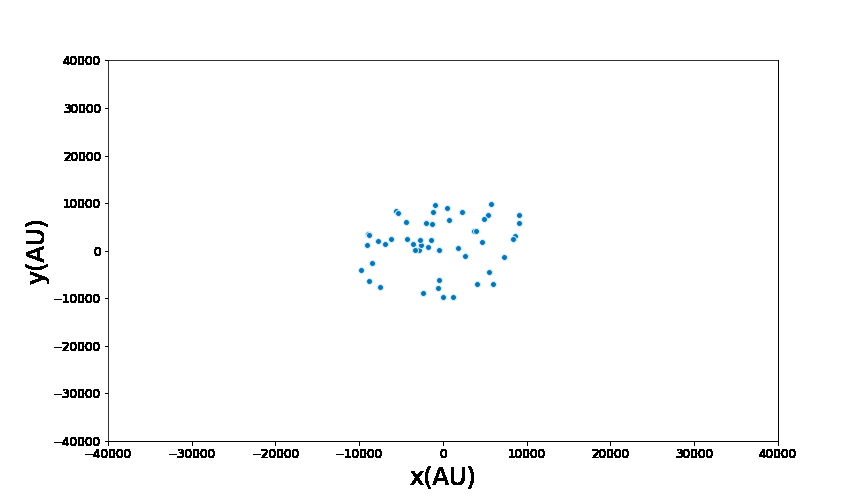

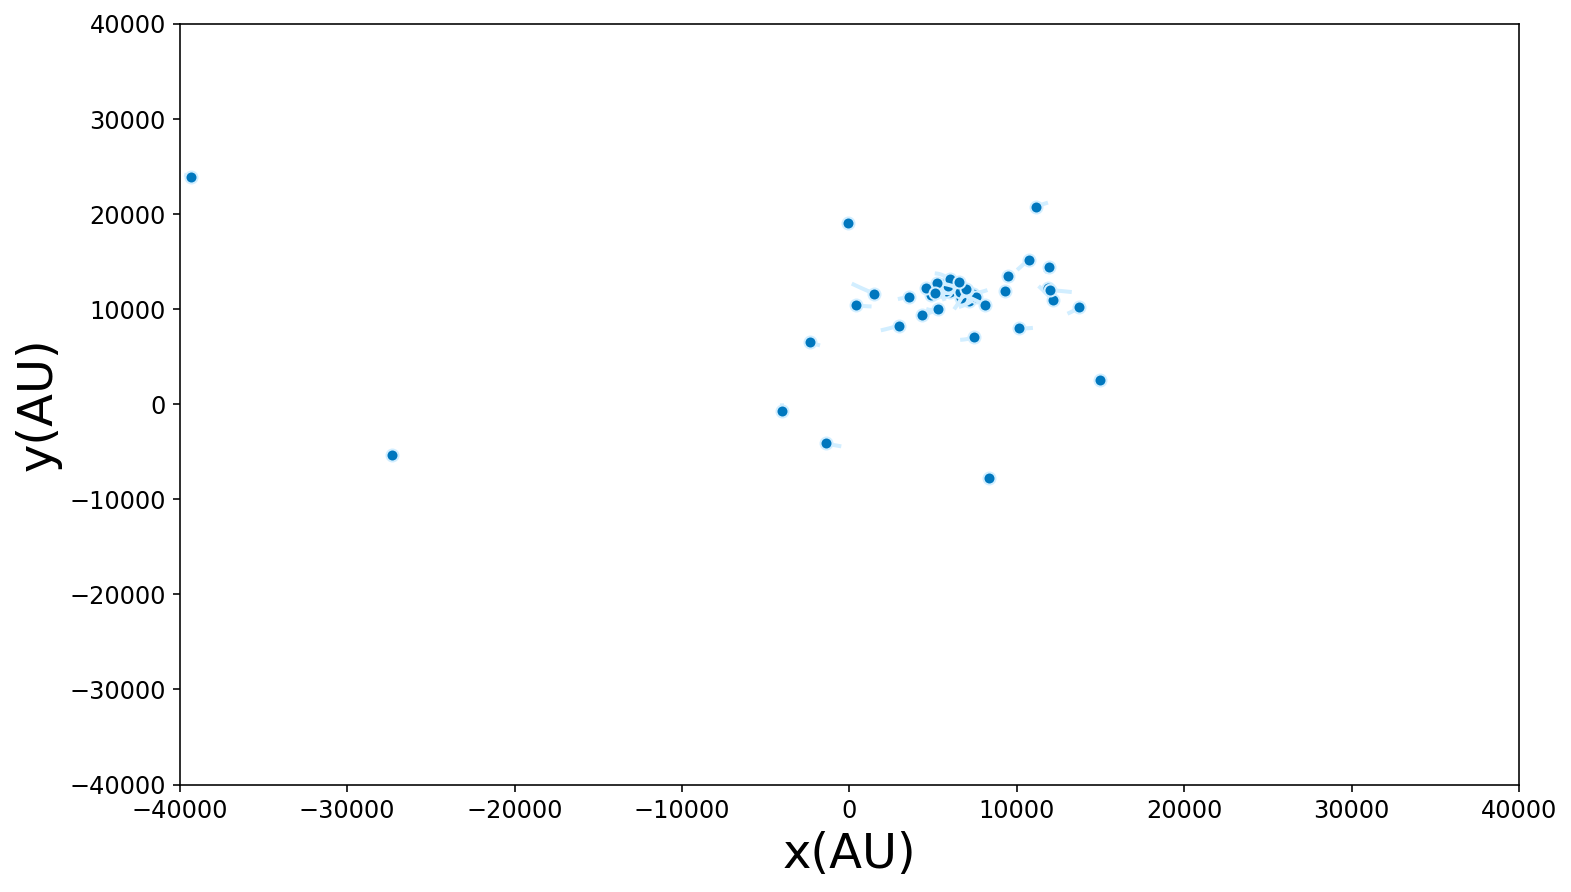

In [107]:
#>>>PROBLEM: P4.5.3

#First we will sample 3000 stars in 2D space with 2D velocity
nStar=50
np.random.seed(1234)

X = np.random.uniform(size=(nStar, 2))*2e4 - 1e4

V = np.zeros((nStar, 2))
M = np.ones((nStar,1))

#ADJUST THE SIMULATION BELOW
allStar = AllStars(X,V,M,isoften=1e3)
Xout=allStar.allsteps(insteps=40000,dt=25.)
tracks=allStar.history()
tracks=np.swapaxes(tracks,0,1)
images=animate(tracks,iN=nStar,xmin=-4e4,xmax=4e4,ymin=-4e4,ymax=4e4,stepsize=100)
imageio.mimsave('./orbit_n.gif', images, fps=10)
Image(open('orbit_n.gif','rb').read())


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.4</span>

First lets run some common sense checks of our simulation. We want to know:

A) What is the max change in the center of mass of the total system?  

B) What is the change in velocity of the system?

C) What is the change in the angular of momentum of the total system from beginning to end?

D) What is the change in energy?

Determine the order-of-magnitude answers to the above questions (for instance, `2.567e-10` would be expressed as `1e-10`, `7.567e-10` would be expressed as `1e-9`, and `2.567` would be expressed as `1e1`, etc.). Report your results as a list of numbers.


In [114]:
#>>>PROBLEM: P4.5.4

def centerOfMass(iVec):
    center=np.mean(iVec,axis=0)
    return center

def angMomentun(iR,iV):
    center=centerOfMass(iR)
    shift=iR-center
    ang=shift[:,0]*iV[:,1]-shift[:,1]*iV[:,0]
    return np.sum(ang,axis=0)

tracks=allStar.history()
comX0=centerOfMass(tracks[0])
comX1=centerOfMass(tracks[-1])
print("com0",comX0,"com1",comX1)
print("delta_com", np.sqrt(np.sum((comX1 - comX0)**2.)))
print()

veltracks=allStar.velhistory()
vcomX0=centerOfMass(veltracks[0])
vcomX1=centerOfMass(veltracks[-1])
print("vel com0",vcomX0,"vel com1",vcomX1)
print("delta_com_vel", np.sqrt(np.sum((vcomX1 - vcomX0)**2.)))
print()

LcomX0=angMomentun(tracks[0],veltracks[0])
LcomX1=angMomentun(tracks[-1],veltracks[-1])
print("L com0",LcomX0,"L com1",LcomX1)
print("delta_com_L", abs(LcomX1 - LcomX0))
print()

enhist=allStar.enhistory()
enhisttot=np.sum(enhist,axis=1)
E0 = enhisttot[0]
E1 = enhisttot[-1]
print("E tot",E0,"E final",E1)
print("delta_E", abs(E1 - E0))


com0 [ 3.63797881e-14 -3.63797881e-14] com1 [ 1.09139364e-13 -1.09139364e-13]
delta_com 1.0289757937229986e-13

vel com0 [4.33680869e-21 4.33680869e-21] vel com1 [-7.64943664e-16  4.99600361e-16]
delta_com_vel 9.13641960156896e-16

L com0 -3.991844056837014 L com1 -29627.317030126487
delta_com_L 29623.32518606965

E tot -15.56147977312628 E final -19.27656657314079
delta_E 3.715086800014511


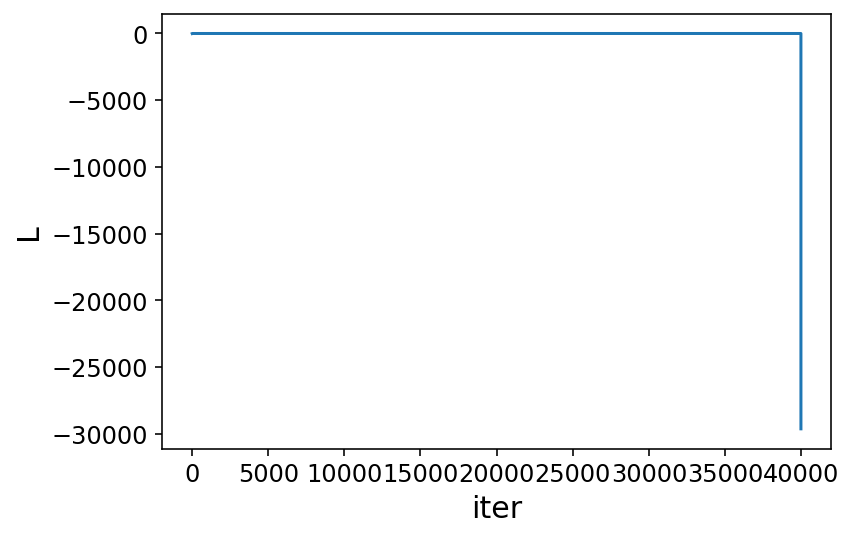

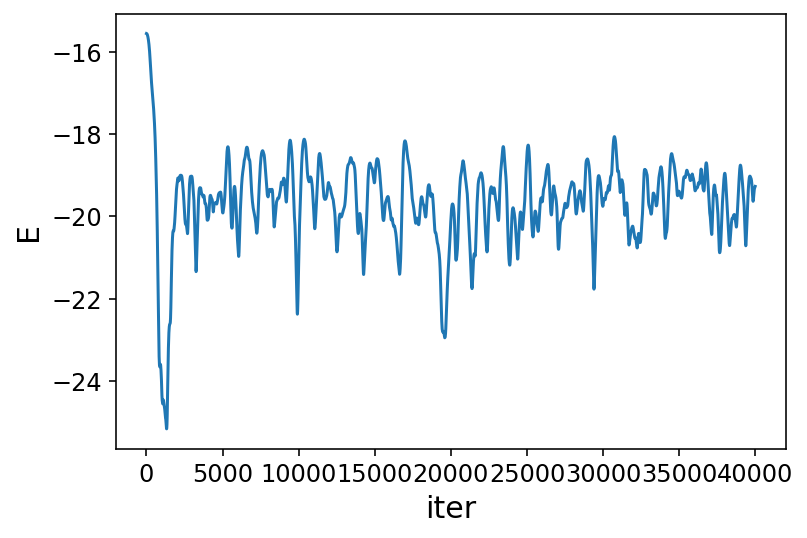

In [115]:
#>>>RUN

##Now some fun plots
def centerOfMassTime(iVec):
    center=np.sum(iVec,axis=1)/iVec.shape[1]
    return center

def shiftCOM(iR):
    center=centerOfMassTime(iR)
    shift=iR
    for pVal in range(iR.shape[1]):
        shift[:,pVal] -= center
    return shift

def angMomentumTime(iR,iV):
    shift=shiftCOM(iR)
    ang=shift[:,:,0]*iV[:,:,1]-shift[:,:,1]*iV[:,:,0]
    return np.sum(ang,axis=1)
    

Ltime=angMomentumTime(tracks,veltracks)
plt.plot(Ltime)
plt.xlabel("iter")
plt.ylabel("L")
plt.show()

plt.plot(enhisttot)
plt.xlabel("iter")
plt.ylabel("E")
plt.show()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.5</span>

Now that we have answered the basic questions, lets go ahead and try to come up with a more detailed analytic answer. Given our above simulation, write a script to show the average density before and after the simulation. Roughly what fraction of stars are > 10k AU before evolving. What fraction are  > 10k after at least 1 Million years of evolution. Report your answer as a list of two numbers, `[frac_before, frac_after]`, with precision `1e-2`.


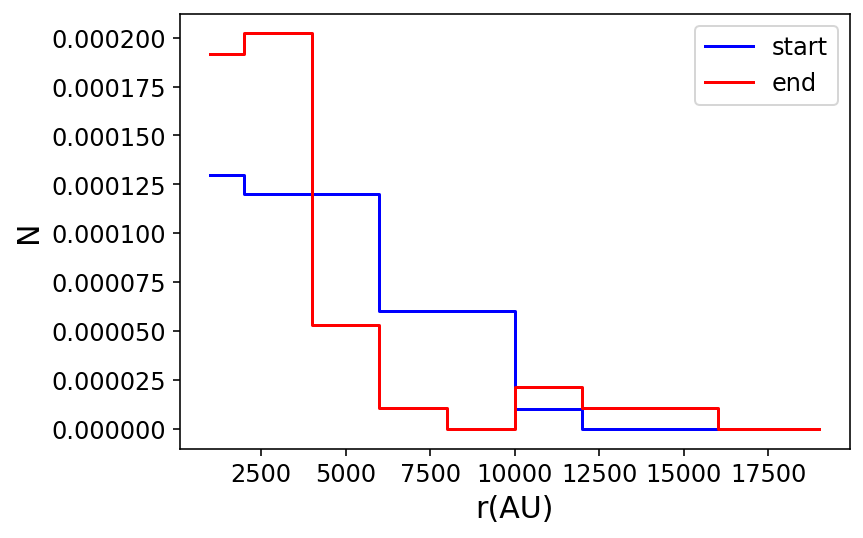

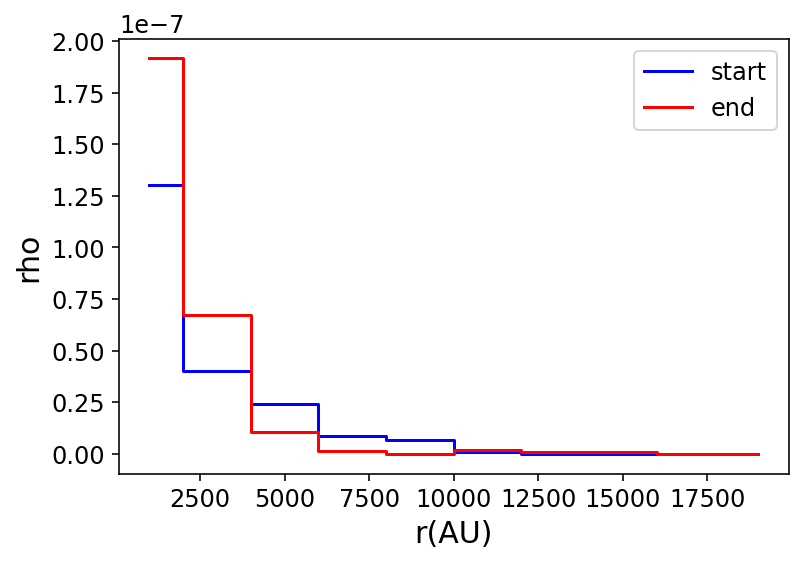

Fraction: 0.02  Updated Fraction 0.14


In [126]:
#>>>PROBLEM: P4.5.5

def makeRadiusHist(iX):
    shift=shiftCOM(iX)
    evts,bin_edges=np.histogram(np.sqrt(shift[:,0]**2+shift[:,1]**2),bins=10,range=[0,2e4],density=True)
    bin_centers=0.5*(bin_edges[1:]+bin_edges[:-1])
    return bin_centers,evts

def plotRadius(iTracks):
    pX0,pY0 = makeRadiusHist(iTracks[0])
    plt.plot(pX0,pY0,drawstyle = 'steps-mid',label='start',c='blue')
    pX1,pY1 = makeRadiusHist(iTracks[-1])
    plt.plot(pX1,pY1,drawstyle = 'steps-mid',label='end',c='red')
    plt.legend()
    plt.xlabel("r(AU)")
    plt.ylabel("N")
    plt.show()

plotRadius(tracks)

#now density => each bin divide by r => rho=N/2pirdr
pX0,pY0 = makeRadiusHist(tracks[0])
pX1,pY1 = makeRadiusHist(tracks[-1])
plt.plot(pX0,pY0/pX0,drawstyle = 'steps-mid',label='start',c='blue')
plt.plot(pX1,pY1/pX1,drawstyle = 'steps-mid',label='end',c='red')
plt.legend()
plt.xlabel("r(AU)")
plt.ylabel("rho")
plt.show()

def fraction(iX,iR=50000):
    return np.sum(np.sqrt(iX[:,0]**2 + iX[:,1]**2) > iR) / iX.shape[0]

frc0=fraction(tracks[0],1e4)
frc1=fraction(tracks[-1],1e4)
print("Fraction:",frc0," Updated Fraction",frc1)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.6</span>

Now lets start to look at how the galaxy evolves. Plot the average radial velocity vs. radius of the toy galaxy what is the average radial velocity of the inner 80% compared to the last 20%? Report your answer as a list of two numbers, `[vel_inner, vel_outer]` with units of AU/year, with precision `1e-1`. Just gauge by eye.

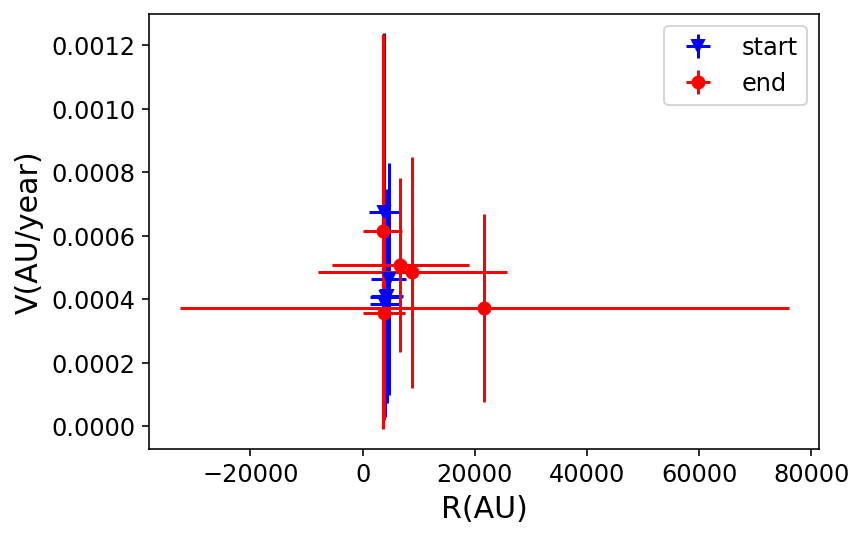

In [125]:
#>>>PROBLEM: P4.5.6

def plotRvsV(iR,iV,iNbins=5): 
    #Sort data array in R
    sort = np.argsort(iR)
    #split data into nbins
    corrXsort = iR[sort]
    corrYsort = iV[sort]
    ncands=len(iV)//iNbins
    corrXsort = np.reshape(corrXsort,(ncands,iNbins))
    corrXmean = np.mean(corrXsort, axis=0)
    corrXrms  = np.std(corrXsort, axis=0)

    corrYsort = np.reshape(corrYsort,(ncands,iNbins))
    corrYmean = np.mean(corrYsort, axis=0)
    corrYrms  = np.std(corrYsort, axis=0)
    return corrXmean,corrYmean,corrXrms,corrYrms

##Now some fun plots
def shiftCOM(iR):
    center=centerOfMass(iR)
    shift=iR
    #shift it
    for pVal in range(iR.shape[0]):
        shift[pVal] -= center 
    return shift

def velCOM(iX,iV):
    #compute projected radial velocity (r x v)/|r| (note iX[:,0] is the first element of all particles)
    r = np.sqrt(np.sum(iX**2, axis=1))
    vproj = np.cross(iX, iV) / r
    return vproj
    
def plotRotation(veltracks,tmptracks):
    shiftX=shiftCOM(tmptracks[0])
    velX=velCOM(shiftX,veltracks[0])
    pX0,pY0,pEX0,pEY0 = plotRvsV(np.sqrt(shiftX[:,0]**2+shiftX[:,1]**2),np.abs(velX))
    plt.errorbar(pX0,pY0,pEY0,pEX0,marker='v',linestyle='none',label='start',c='blue')
    shiftX=shiftCOM(tmptracks[-1])
    pX1,pY1,pEX1,pEY1 = plotRvsV(np.sqrt(shiftX[:,0]**2+shiftX[:,1]**2),np.abs(velX))
    plt.errorbar(pX1,pY1,pEY1,pEX1,marker='o',linestyle='none',label='end',c='red')
    plt.legend()
    plt.xlabel("R(AU)")
    plt.ylabel("V(AU/year)")
    plt.show()

tracks=allStar.history()
veltracks=allStar.velhistory()
plotRotation(veltracks,tracks)


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.7</span>

We know that the discovery of flat rotation curves (flat radial velocity as a function of radius from the galaxy) led to an explanation for dark matter. What is the reason our simulation can produce this effect? Select ALL that apply.

A) We are lacking Matter interactoins\
B) We neglect general relativsitic effects\
C) Our softening term doesn’t add other dynamics, it just removes numerial instabilities\
D) Our bodies should have varying mass as well\
E) We didn’t simulate enough stars

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.5.8</span>

Lets simulate a simplified matter galaxy (not dark matter). To do this we need to an insert a force that is not gravitational. What we will do is once the stars get close to each other, we negate the force on them. Namely 

$$
\forall \Delta_{ij} < \epsilon\\ \rightarrow F_{ij} = -F_{ij}^{Grav} = \frac{G m_{i}m_{j}}{|\vec{r}_{i}-\vec{r}_{j}|^3} \vec{r}_{i}-\vec{r}_{j}
$$

The idea is to envision the stars as elastic balls that scatter on each other, the aim here is to emulate a much stronger force that acts locally once the matter is close to each other. In reality this is done treaing the star as a fluid and running a simulation similar to the other probelms. 

Now modify the force in the code below, and compare the rotation curve. What happens to the ratio of the velocity inner 90% of stars compared to the 10%?

Selecto ALL statements that reflect your observations:

A) A central core is still formed\
B) Some of the outer stars fly further out of the galaxy\
C) The rotation curve is much (> x2) higher in the central core\
D) The rotation curve appears to have a slightly faster central core, but it is hard to tell\
E) The rotation curve appears to have a slightly denser central core, but it is hard to tell\
F) The stars do not cluster up at all



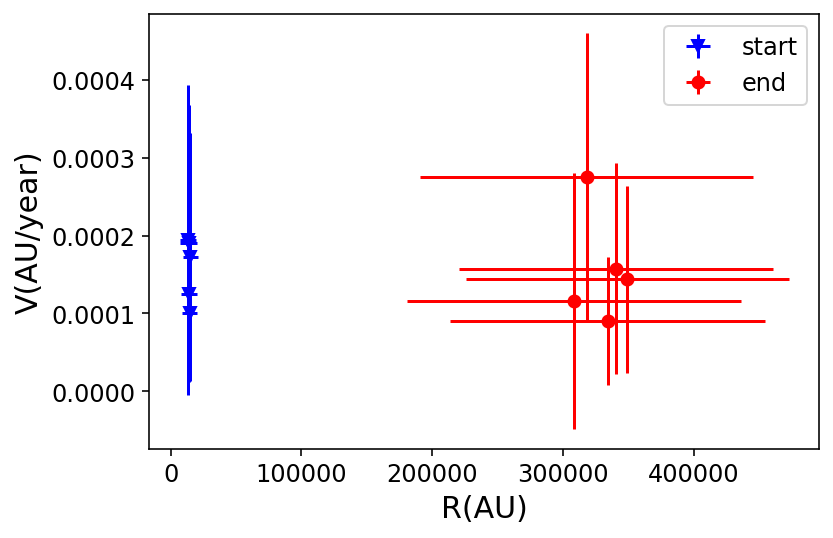

/Users/Josh/miniconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


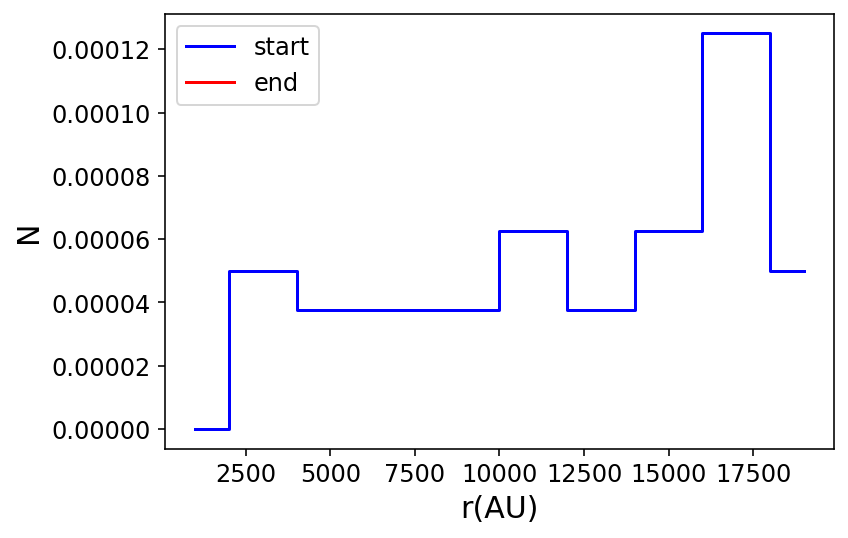

In [127]:
#>>>PROBLEM: P4.5.8

#this function computes the force and potential energy of the system
def forcefunction(iR,iMass,iSoften):
    xpos=iR[:,0:1]
    ypos=iR[:,1:2]
    dx = xpos.T - xpos
    dy = ypos.T - ypos
    dr2  = dx**2 + dy**2 + iSoften**2
    dr1  = dr2**(-0.5)
    dr2[dr2>0] = dr2[dr2>0]**(-1.5)
    dr2b = np.where(dr2 < (dx**2 + dy**2))#selection on events dr2 < X
    dr2[dr2b] = -dr2[dr2b] #code to change forces
    ax   = Gmod * (dx*dr2) @ iMass
    ay   = Gmod * (dy*dr2) @ iMass
    a = np.hstack((ax,ay))
    pot = -1.*Gmod * dr1 @ iMass
    return a,pot

nStar=50
np.random.seed(1234)
X = np.random.uniform(-1,1,(nStar, 2)) * 2e4 
V = np.zeros((nStar, 2))
M = np.ones((nStar,1))

allIntStar = AllStars(X,V,M,ibase=False,isoften=1e3)
Xout2=allIntStar.allsteps(insteps=40000,dt=25.)
tracks2=allIntStar.history()
veltracks2=allIntStar.velhistory()
plotRotation(veltracks2,tracks2)
plotRadius(tracks2)
plt.show()

<!--start-block-->
<a name='section_4_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">P4.6 Training a NN to Find Tau Leptons

| [Top](#section_4_0) | [Previous Section](#section_4_5) | [Problems](#problems_4_6) |

<h3>Overview</h3>

Now we are going to do a classic deep learning classificaiton problem. This uses real simulation that we are using for the current Tau Trigger in the CMS experiment. The strategy here is to build a deep learning algorithm that is small so we can embed this on a special chip that can run this neural network roughly 40 millions times per second to look for tau leptons. The output of this neural network is a probability of whether the object we pass into it is a tau or not. 

For this training, we will use 1 signal sample consisting of well defined taus from siulated Higgs to tau tau decys, and two backgrounds: the unbiased simulated background called minimum bias, a biased high momentum background sample of jets we will call QCD. The second sample enables the neural network to continue to work at high momentum well. In practice, you will not notice the two background samples, since we merge them for you before hand. Finally, we will train two neural networks a regression, and a discrimintor. This means we will have two truth values we want to train to, the true tau pT for the regression, and separating signal and background. 

<h3>Data</h3>

One data file is located in the `pset4/data` directory in the git repository.

You will also need 2 datasets available on dropbox here:
* https://www.dropbox.com/scl/fi/kgsxcqdiji7fj8g7k70nx/test_bkg_v12_emseed.root?rlkey=itzrtjvwejqxs7vyzf4k75p0l&dl=0
* https://www.dropbox.com/scl/fi/jdljan7gw8bt6n30b0rnm/test_sig_v12_emseed.root?rlkey=w7a5jqifr6u1kx0nm1ktbaq2z&dl=0

If you are working locally, download these files and move them to the `pset4/data` directory. If you are working in COLAB, run the cells below.


In [ ]:
#>>>RUN: P4.0-runcell00

#run this cell if using COLAB,
#to download the file: test_qcd_v12_emseed.root
#NOTE: this will create the directory pset4/data

"""
!git init
!git remote add -f origin https://github.com/mit-physics-data/psets/
!git config core.sparseCheckout true
!echo 'pset4/data' >> .git/info/sparse-checkout
!git pull origin main
"""

In [ ]:
# NOTE: some files are too large to include in the original repository,
# so you must download them using the options below
#
# Ways to download:
#     1. Copy/paste the link (replace =0 with =1 to download automatically)
#     2. Use the wget commands below (works in Colab, but you may need to install wget if using locally)
#
# Location of files:
#     If working with files locally, move the files to the directory 'data'
#
# Using wget: (works in Colab)
#     Upon downloading, the code below will move them to the appropriate directory: pset4/data

"""
#run these lines if using COLAB,
#to download the file: test_bkg_v12_emseed.root
!wget https://www.dropbox.com/scl/fi/kgsxcqdiji7fj8g7k70nx/test_bkg_v12_emseed.root?rlkey=itzrtjvwejqxs7vyzf4k75p0l&dl=0
!mv test_bkg_v12_emseed.root?rlkey=itzrtjvwejqxs7vyzf4k75p0l pset4/data/test_bkg_v12_emseed.root #rename #rename

#run these lines if using COLAB,
#to download the file: test_sig_v12_emseed.root
!wget https://www.dropbox.com/scl/fi/jdljan7gw8bt6n30b0rnm/test_sig_v12_emseed.root?rlkey=w7a5jqifr6u1kx0nm1ktbaq2z&dl=0
!mv test_sig_v12_emseed.root?rlkey=w7a5jqifr6u1kx0nm1ktbaq2z pset4/data/test_sig_v12_emseed.root #rename #rename

"""

In [1]:
#NOTE: install these libraries if you have not done so

#!pip install uproot
#!pip install pylorentz

import random
import uproot
import torch
import numpy as np
import matplotlib.pyplot as plt


To start with, we will just load the first variable in the dataset, this first variable is the going to be the leading particle momentum in a jet cone of particles. Ultimately, we will load the full 4 vectors and particle ids of the top 10 particles. 




Signal Samples 100000 label: 1.0
Bkg Samples 100000 label: 0.0
QCD Samples 100000 label: 0.0


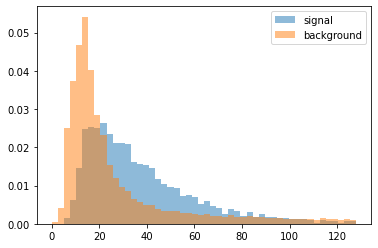

In [2]:
seed = 1111
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed) 

def create_train_test_data(dir_path,iNVars=1,maxnum=100000):        
    #Might have to change the version for other ntuple files
    sig = uproot.open(dir_path+"data/test_sig_v12_emseed.root")
    bkg = uproot.open(dir_path+"data/test_bkg_v12_emseed.root")
    qcd = uproot.open(dir_path+"data/test_qcd_v12_emseed.root")

    sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()
    bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()
    qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

    truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array())

    reco_pt_sig  = sig['ntuplePupSingle']['tree']['pt'].array()
    deltaR_sig   = sig['ntuplePupSingle']['tree']['gendr1'].array()
    eta_sig      = sig['ntuplePupSingle']['tree']['geneta1'].array()
    selection_sig = (reco_pt_sig > 12.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
    selection_bkg = (bkg['ntuplePupSingle']['tree']['pt'].array() > 12) 
    selection_qcd = (qcd['ntuplePupSingle']['tree']['pt'].array() > 12)

    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig][0:maxnum]))
    Y_sig = np.full(X_sig.shape[0], 1.)

    sig_pt = np.asarray(reco_pt_sig[selection_sig][0:maxnum])
    Y_sig_pT = truth_pt_sig[selection_sig][0:maxnum]

    X_bkg    = np.nan_to_num(np.asarray(bkg_input)[selection_bkg][0:maxnum])
    Y_bkg    = np.full(X_bkg.shape[0], 0.)
    Y_bkg_pT = np.ones(Y_bkg.shape)
    
    X_qcd    = np.nan_to_num(np.asarray(qcd_input)[selection_qcd][0:maxnum])
    Y_qcd    = np.full(X_qcd.shape[0], 0.)
    Y_qcd_pT = np.ones(Y_qcd.shape)
    
    print("Signal Samples",len(Y_sig),"label:",Y_sig[0])
    print("Bkg Samples",len(Y_bkg),"label:",Y_bkg[0])
    print("QCD Samples",len(Y_qcd),"label:",Y_qcd[0])
    
    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    Y_train_tauID = np.concatenate([Y_sig, Y_bkg, Y_qcd])
    Y_train_pT    = np.concatenate([Y_sig_pT / sig_pt, Y_bkg_pT, Y_qcd_pT])
    
    #cleaning
    X_train[abs(X_train) > 1e+9] = 0.    
    if iNVars > 0:
        X_train = X_train[:,0:iNVars]
    
    #convert to pytorch
    X_train       = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tauID = torch.tensor(Y_train_tauID, dtype=torch.float32)
    Y_train_pT    = torch.tensor(Y_train_pT, dtype=torch.float32)
    return X_train, Y_train_tauID, Y_train_pT

#set directory path
#dir_path = "pset4/" #if using colab
dir_path = "" #if using local directory

X_train_tauID, Y_train_tauID,Y_train_pT_regress = create_train_test_data(dir_path)
plt.hist(X_train_tauID[:,0][Y_train_tauID == 1],bins=50,range=(0,128),label="signal",alpha=0.5,density=True)
plt.hist(X_train_tauID[:,0][Y_train_tauID == 0],bins=50,range=(0,128),label="background",alpha=0.5,density=True)
plt.legend()
plt.show()

<a name='problems_4_6'></a>     

| [Top](#section_4_0) | [Restart Section](#section_4_6) |

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.1</span>

Now we want to make to split the dataset into 3 components so that we can validate the training. These will be 

 * Train => This is the dataset we train the neural network on
 * Valid => Ths is the dataset that we use to check the loss doesn't overtrain while we train
 * Test  => This is the dataset that we use to test the performance
 
In the code below, split the data into  20% testing and training, and then split training into a subsequent training and validation with 20% being for valdiation. What yields do you have for testing, training, and validation in `[test,train,validation]`?

In [3]:
#>>>PROBLEM: P4.6.1

def splitDataTestValid(iX,iY,test_frac=0.2,val_frac=0.2):
    alldataset = torch.utils.data.TensorDataset(iX,iY)
    #see https://pytorch.org/docs/stable/data.html
    testdataset, trainvaldataset = torch.utils.data.random_split(alldataset, [test_frac,1-test_frac]) #YOUR CODE HERE
    traindataset,valddataset     = torch.utils.data.random_split(trainvaldataset, [1-val_frac,val_frac]) #YOUR CODE HERE
    return traindataset,testdataset,valddataset

train,test,valid = splitDataTestValid(X_train_tauID, Y_train_tauID)
print(len(test),len(train),len(valid))

60000 192000 48000


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.2</span>

Ok, now lets create a one layer neural network that applys a sigmoid output to the output of that one layer. Create the network and then apply it directly to the test dataset. What is the mean output? Report a number with precision `1e-3`.

In [4]:
#>>>PROBLEM: P4.6.2

class NN_1layer(torch.nn.Module):
    def __init__(self,ninputs):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.output(x)
        return x

torch.random.manual_seed(1234) 
test_model = NN_1layer(1)
output = test_model(test[:][0])
print(output.mean())

tensor(0.0610, grad_fn=<MeanBackward0>)


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.3</span>

Ok, now lets compute the loss for this network. Use Binary Cross entropy on the test dataset. What is your loss? Report a number with precision `1e-1`.

In [5]:
#>>>PROBLEM: P4.6.3

criterion = torch.nn.BCELoss() ##Add binary cross entropy loss
loss = criterion(output.flatten(),label)
print(loss)

NameError: name 'label' is not defined

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.4</span>

Ok, now lets do the whole training loop, we will write a function that takes the loss, model, and trains it with a fixed batchsize using dataloaders. What is the testing, training, validation loss after 10 epochs? Report your answer as a list of number `[test,train,valid]` with precision `1e-2`.

[1,  192] loss: 4.5071  val loss: 0.6561
[2,  192] loss: 0.6241  val loss: 0.6120
[3,  192] loss: 0.6094  val loss: 0.6098
[4,  192] loss: 0.6088  val loss: 0.6098
[5,  192] loss: 0.6088  val loss: 0.6099
[6,  192] loss: 0.6089  val loss: 0.6100
[7,  192] loss: 0.6093  val loss: 0.6107
[8,  192] loss: 0.6090  val loss: 0.6102
[9,  192] loss: 0.6091  val loss: 0.6119
[10,  192] loss: 0.6092  val loss: 0.6112


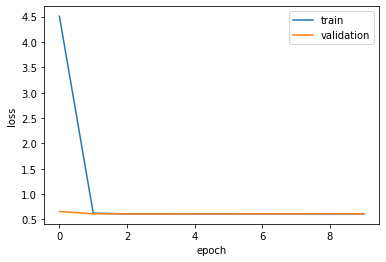

tensor(0.6116, grad_fn=<BinaryCrossEntropyBackward0>) 0.6091828091690937 0.6112226781745752


In [7]:
#>>>PROBLEM: P4.6.4

def train_model(iModel,iCriterion,iTrain,iValid,nepochs=5,learning_rate=0.01,iBatch=1000):
    optimizer   =  torch.optim.Adam(iModel.parameters(), lr=learning_rate) #Use Adam optimizer with a learning rate of 0.01 
    history     = {'loss':[], 'val_loss':[]}
    #dataloaders to cache things (not really needed, but good to know)
    trainloader = torch.utils.data.DataLoader(iTrain,batch_size=iBatch,shuffle=True)
    valloader   = torch.utils.data.DataLoader(iValid,batch_size=iBatch,shuffle=True)
    
    for epoch in range(nepochs):
        current_loss = 0.0 #rezero loss
        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = iModel(inputs)
            loss = iCriterion(outputs.flatten(), labels)
            loss.backward()
            #backpropagate loss
            #step optimizer
            optimizer.step()
            current_loss += loss.item()
        
            if i == len(trainloader)-1:
                current_val_loss = 0.0
                with torch.no_grad():#disable updating gradient
                    for iv, vdata in enumerate(valloader):
                        val_inputs, val_labels = vdata
                        val_loss = iCriterion(iModel(val_inputs).flatten(), val_labels) #validation loss
                        current_val_loss += val_loss.item()
                    print('[%d, %4d] loss: %.4f  val loss: %.4f' % 
                          (epoch + 1, i + 1, current_loss/float(i+1) , current_val_loss/float(len(valloader))))
                history['loss'].append(current_loss/float(i+1))
                history['val_loss'].append(current_val_loss/float(len(valloader)))
    return history

history=train_model(test_model,criterion,train,valid,nepochs=10)
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

testloss=criterion(test_model(test[:][0]).flatten() ,test[:][1])
print(testloss,history['loss'][-1],history['val_loss'][-1])

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.5 </span>

Now lets test the performance of this discriminator by computing a ROC curve. To do this, we will

a) plot the signal and background output of the neural network\
b) compute the Reciever operator chacteristic\
c) Compute the Area under a curve (AUC)

What is the AUC you achieve? Report a number with precision `1e-2`.

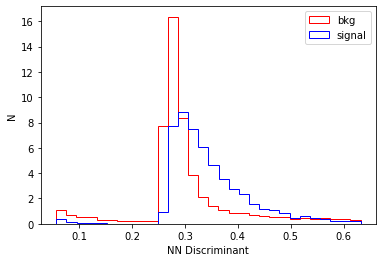

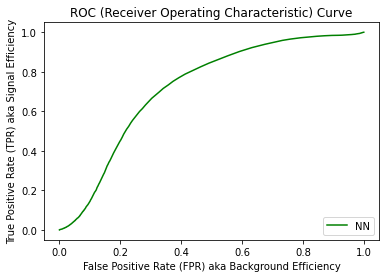

AUC: 0.7195590931858674


In [17]:
#>>>PROBLEM: P4.6.5

from sklearn import metrics


output=test_model(test[:][0]).flatten()
label= test[:][1] #labels on the test dataset

#now plot it
plt.hist(output[label==0].detach().numpy(),histtype='step',color='r',density=True,label='bkg',bins=30)
plt.hist(output[label==1].detach().numpy(),histtype='step',color='b',density=True,label='signal',bins=30)
plt.xlabel('NN Discriminant')
plt.ylabel('N')
plt.legend()
plt.show()

def compute_ROC(labels, predicts, npts=501):
    cutvals = np.linspace(0., 1., npts) #make a line from min to max with npoints
    tot0 = float(len(labels[labels==0]))#bkg
    tot1 = float(len(labels[labels==1]))#sig
    tpr = []
    fpr = []
    for c in cutvals:
        passbkg=(labels == 0 ) & (predicts > c)#condition for label=0 and prediction > c (aka cutval)
        passsig= (labels == 1 ) & (predicts > c) #condition for label=1 and prediction > c (aka cutval)
        fpr.append(float(len(predicts[passbkg]))/tot0)
        tpr.append(float(len(predicts[passsig]))/tot1)
    return np.array(fpr),np.array(tpr)

test_model_roc = compute_ROC(label,output)
plt.plot(test_model_roc[0],test_model_roc[1],'g-',label="NN")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

print("AUC:",metrics.auc(test_model_roc[0], test_model_roc[1] ) ) #compute AUC

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.6</span>

Ok, Now we have run through a very simple NN. Lets go ahead and load the full dataset and train, start with 10 epochs. The full dataset has 80 inputs, these inputs start form a jet (a cone in a collision):

 * pT of the first particle
 * theta (really eta) of the first particle from the center of the jet
 * phi of the first particle from the center of the jet
 * one hot coded id of the particle  (this is a vector of 5 elements that are zero or 1)
   * [pion, electron, muon, photon, neutral hadron]
 * the above 8 variables for the top 10 particles in the jet
 
What is the `[test,train,valid]` loss after 10 epochs? Report your answer as a list of numbers with precision `1e-2`.

Signal Samples 100000 label: 1.0
Bkg Samples 100000 label: 0.0
QCD Samples 100000 label: 0.0
torch.Size([192000, 80])
[1,  192] loss: 0.4485  val loss: 0.4034
[2,  192] loss: 0.4089  val loss: 0.3998
[3,  192] loss: 0.4065  val loss: 0.3991
[4,  192] loss: 0.4054  val loss: 0.3982
[5,  192] loss: 0.4055  val loss: 0.4005
[6,  192] loss: 0.4060  val loss: 0.4044
[7,  192] loss: 0.4051  val loss: 0.3982
[8,  192] loss: 0.4053  val loss: 0.3988
[9,  192] loss: 0.4055  val loss: 0.3979
[10,  192] loss: 0.4057  val loss: 0.3986


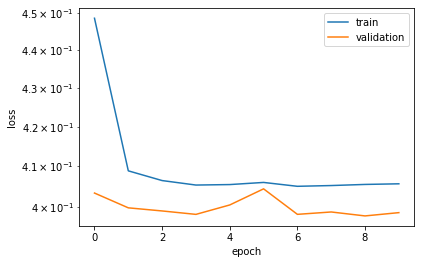

tensor(0.4059, grad_fn=<BinaryCrossEntropyBackward0>) 0.4056842828479906 0.39864936160544556


In [21]:
#>>>PROBLEM: P4.6.6


X_train_tauID, Y_train_tauID,Y_train_pT_regress = create_train_test_data(dir_path,iNVars=-1)
train,test,valid = splitDataTestValid(X_train_tauID, Y_train_tauID)
print(train[:][0].shape)
test_model = NN_1layer(80)
history=train_model(test_model,criterion,train,valid,nepochs=10)
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.yscale("log")
plt.show()

testloss=criterion(test_model(test[:][0]).flatten() ,test[:][1]) #apply this to the test loss
print(testloss,history['loss'][-1],history['val_loss'][-1])

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.7</span>

Ok, Now Lets go ahead and build a 3 layer network with relu activations, and 50 hidden parameters, for the intermediate layers. What is the [test,train,valid] loss after 10 epochs? Report your answer as a list of numbers with precision `2e-2`.

[1,  192] loss: 0.3563  val loss: 0.3127
[2,  192] loss: 0.3168  val loss: 0.3118
[3,  192] loss: 0.3121  val loss: 0.3067
[4,  192] loss: 0.3107  val loss: 0.3170
[5,  192] loss: 0.3087  val loss: 0.3118
[6,  192] loss: 0.3073  val loss: 0.3127
[7,  192] loss: 0.3065  val loss: 0.3040
[8,  192] loss: 0.3057  val loss: 0.3043
[9,  192] loss: 0.3038  val loss: 0.3027
[10,  192] loss: 0.3030  val loss: 0.3060


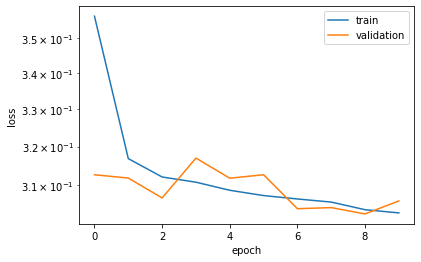

tensor(0.3100, grad_fn=<BinaryCrossEntropyBackward0>) 0.3029844469080369 0.305982477342089


In [24]:
#>>>PROBLEM: P4.6.7

class NN_3layer(torch.nn.Module):
    def __init__(self,ninputs):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,50)
        self.act1 = torch.nn.ReLU() #Relu activation
        self.fc2 = torch.nn.Linear(50,50) #one linear layer
        self.act2 = torch.nn.ReLU() #Relu activation
        self.fc3 = torch.nn.Linear(50,1) #one linear layer
        self.output = torch.nn.Sigmoid() #apply a sigmoid

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.output(x)
        return x

torch.random.manual_seed(1234) 
test_model = NN_3layer(80)
history=train_model(test_model,criterion,train,valid,nepochs=10)
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.yscale("log")
plt.show()

testloss=criterion(test_model(test[:][0]).flatten() ,test[:][1]) #apply this to the test loss
print(testloss,history['loss'][-1],history['val_loss'][-1])

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.8</span>

Ok, lets train this guy for another 30 epochs. Again, what is the [test,train,valid] loss after 10 epochs? Report your answer as a list of numbers with precision `2e-2`.

[1,  192] loss: 0.3035  val loss: 0.3019
[2,  192] loss: 0.3019  val loss: 0.3050
[3,  192] loss: 0.3011  val loss: 0.3028
[4,  192] loss: 0.2998  val loss: 0.3024
[5,  192] loss: 0.3001  val loss: 0.3065
[6,  192] loss: 0.2989  val loss: 0.3017
[7,  192] loss: 0.2988  val loss: 0.3044
[8,  192] loss: 0.2976  val loss: 0.3025
[9,  192] loss: 0.2970  val loss: 0.3009
[10,  192] loss: 0.2967  val loss: 0.3004
[11,  192] loss: 0.2961  val loss: 0.2992
[12,  192] loss: 0.2965  val loss: 0.3015
[13,  192] loss: 0.2960  val loss: 0.3015
[14,  192] loss: 0.2948  val loss: 0.3039
[15,  192] loss: 0.2950  val loss: 0.3005
[16,  192] loss: 0.2940  val loss: 0.3013
[17,  192] loss: 0.2944  val loss: 0.2986
[18,  192] loss: 0.2934  val loss: 0.3017
[19,  192] loss: 0.2927  val loss: 0.3014
[20,  192] loss: 0.2934  val loss: 0.2993
[21,  192] loss: 0.2927  val loss: 0.2997
[22,  192] loss: 0.2924  val loss: 0.3035
[23,  192] loss: 0.2926  val loss: 0.3028
[24,  192] loss: 0.2912  val loss: 0.2973
[

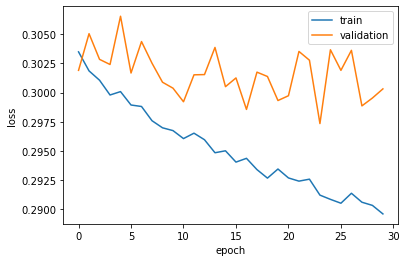

tensor(0.3057, grad_fn=<BinaryCrossEntropyBackward0>) 0.28959924743200344 0.3003142736852169


In [26]:
#>>>PROBLEM: P4.6.8

history=train_model(test_model,criterion,train,valid,nepochs=30)
plt.plot(history['loss'],label='train')
plt.plot(history['val_loss'],label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

testloss=criterion(test_model(test[:][0]).flatten(),test[:][1])
print(testloss, history['loss'][-1],history['val_loss'][-1])

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.9</span>

Ok, now plot the ROC curve. What is the AUC? Report your answer as number with precision `1e-2`.

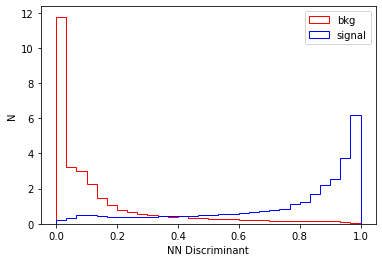

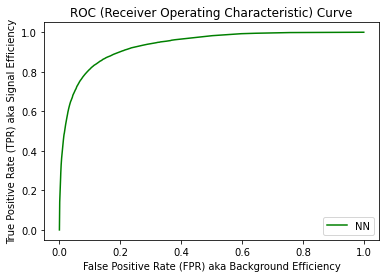

AUC: 0.9337050831881664


In [27]:
#>>>PROBLEM: P4.6.5

from sklearn import metrics


output=test_model(test[:][0]).flatten()
label= test[:][1] #labels on the test dataset

#now plot it
plt.hist(output[label==0].detach().numpy(),histtype='step',color='r',density=True,label='bkg',bins=30)
plt.hist(output[label==1].detach().numpy(),histtype='step',color='b',density=True,label='signal',bins=30)
plt.xlabel('NN Discriminant')
plt.ylabel('N')
plt.legend()
plt.show()

def compute_ROC(labels, predicts, npts=501):
    cutvals = np.linspace(0., 1., npts) #make a line from min to max with npoints
    tot0 = float(len(labels[labels==0]))#bkg
    tot1 = float(len(labels[labels==1]))#sig
    tpr = []
    fpr = []
    for c in cutvals:
        passbkg=(labels == 0 ) & (predicts > c)#condition for label=0 and prediction > c (aka cutval)
        passsig= (labels == 1 ) & (predicts > c) #condition for label=1 and prediction > c (aka cutval)
        fpr.append(float(len(predicts[passbkg]))/tot0)
        tpr.append(float(len(predicts[passsig]))/tot1)
    return np.array(fpr),np.array(tpr)

test_model_roc = compute_ROC(label,output)
plt.plot(test_model_roc[0],test_model_roc[1],'g-',label="NN")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

print("AUC:",metrics.auc(test_model_roc[0], test_model_roc[1] ) ) #compute AUC

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.10</span>

Now apply a cut on the discriminator and compute the efficiency vs. leading particle pt (first input). What is the NN doing? For example, examine the efficiency for pt = 30 GeV and pt = 100 GeV.

Try this out, then consider which of the following statements reflect your observations. Select ALL the apply.

A) The signal efficiency has a turn on as a function of leading pT getting higher rapidly until its above 80% and then leveling off\
B) The signal efficiency drops quickly and has a small eff ( 50%) at pT > 100 GeV\
C) The signal efficiency is always high ( > 80%) for all pTs even below 20 GeV\
D) The background efficiency peaks at 30 GeV with an efficiency of around 30%\
E) The background efficiency peaks at high pT (> 50 GeV) with an efficiency of around 30%\
F) The backround effiecncy goes above 50% at some pT

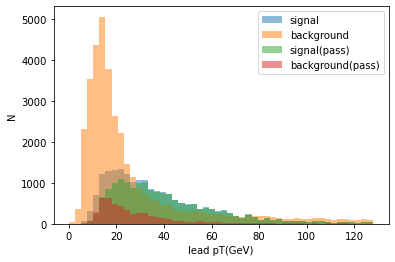

/var/folders/03/b5tt622d05n71qt51ysytbyc0000gq/T/ipykernel_50511/2670497967.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(bincenter,countsSC/countsS,marker='.',label='signal')


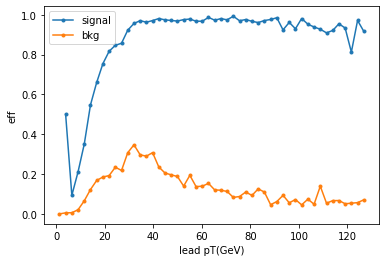

In [29]:
#>>>PROBLEM: P4.6.10

passcut = 0.4 #cut on NN at crossing point

countsS,bins,_ = plt.hist(test[:][0][:,0][label==1.],bins=50,range=(0,128),label="signal",alpha=0.5)
countsB,bins,_ = plt.hist(test[:][0][:,0][label==0.],bins=50,range=(0,128),label="background",alpha=0.5)
countsSC,bins,_ = plt.hist(test[:][0][:,0][(label==1.) & (output>passcut)],bins=50,range=(0,128),label="signal(pass)",alpha=0.5)
countsBC,bins,_ = plt.hist(test[:][0][:,0][(label==0.) & (output>passcut)],bins=50,range=(0,128),label="background(pass)",alpha=0.5)
plt.legend()
plt.xlabel("lead pT(GeV)")
plt.ylabel("N")
plt.show()

bincenter = 0.5*(bins[1:] + bins[:-1])
plt.plot(bincenter,countsSC/countsS,marker='.',label='signal')
plt.plot(bincenter,countsBC/countsB,marker='.',label='bkg')
plt.legend()
plt.ylabel('eff')
plt.xlabel("lead pT(GeV)")
plt.show()


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Problem 4.6.11</span>

Finally, lets see if we can use this NN to find a hidden signal in the data. We will construct a dataset with a mystery mass peak comprising two taus that is injected to background events at the 1.5 percent level (750 events in 50k). Given the output variables of the two taus, find the mass of the hidden signal. Report your answer as a number with precision `1e1`.

NOTE: This is hard, especially to do it convincingly!

In [31]:
!pip install pylorentz

  Preparing metadata (setup.py) ... done
  Created wheel for pylorentz: filename=pylorentz-0.3.3-py3-none-any.whl size=12084 sha256=729ecf4e18070f713015a42d34c9b7780c86aa903d1193c3e631f61f8ec1bae5
  Stored in directory: /Users/Josh/Library/Caches/pip/wheels/be/44/2c/de11acd8e6c371c3a7b61ce987dd1737702cd5e82db0636b10
Successfully built pylorentz

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [32]:
#>>>PROBLEM: P4.6.11

from pylorentz import Momentum4

sig = uproot.open(dir_path + "data/test_sig_v12_emseed.root")
print(sig['ntuplePupDiTau']['tree'].keys())

['run', 'lumi', 'event', 'event2', 'gendr1', 'genpt1', 'geneta1', 'genphi1', 'genid1', 'gendr2', 'genpt2', 'geneta2', 'genphi2', 'genid2', 'chargedIso1', 'chargedIso2', 'decayId1', 'decayId2', 'dxy1', 'dxy2', 'eta1', 'eta2', 'fullIso1', 'fullIso2', 'm1', 'm2', 'passLoose1', 'passLoose2', 'passTight1', 'passTight2', 'phi1', 'phi2', 'pt1', 'pt2', 'z01', 'z02', 'm1_inputs', 'm2_inputs']


/var/folders/03/b5tt622d05n71qt51ysytbyc0000gq/T/ipykernel_50511/2014163853.py:43: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:276.)
  mvis_mix = torch.tensor(np.append(mvisbkg[0:50000],mvissig[0:750]), dtype=torch.float32)


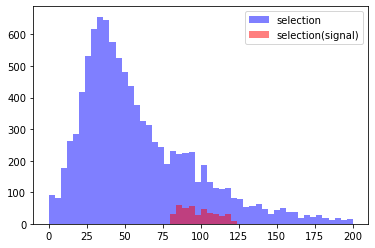

tensor(98.5073)


In [34]:
from pylorentz import Momentum4

def masscompute(iVec1,iVec2):
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], iVec1[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], iVec2[0])
    return (tau_1+tau_2).m

    
def mass_inputsdset(massfunc,idataset):
    mask=(idataset["pt2"].array() > 0)# & abs(idataset["eta2"].array()) < 2.1)
    mask=(abs(idataset["eta2"].array()) < 2.1) & mask
    #mask=(idataset["passLoose1"].array() > 0) & mask
    #mask=(idataset["passLoose2"].array() > 0) & mask
    #varlist=["pt1","eta1","phi1","m1","pt2","eta2","phi2","m2"]
    varlist=["pt1","eta1","phi1","m1","pt2","eta2","phi2","m2"]
    arr=0
    idx=0
    for x in varlist:
        pArr=idataset[x].array(library="np")[mask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: massfunc(iarr[0:4],iarr[4:8]) 
    hmasses = np.array([massc(p) for p in arr[0:50000]])
    inputs1 = idataset['m1_inputs'].array()
    inputs2 = idataset['m2_inputs'].array()
    inputs1 = np.nan_to_num(np.asarray(inputs1)[mask][0:50000])
    inputs2 = np.nan_to_num(np.asarray(inputs2)[mask][0:50000])
    return hmasses,inputs1,inputs2
    
def create_double_train_test_data(dir_path):
    sig = uproot.open(dir_path+"data/test_sig_v12_emseed.root")
    bkg = uproot.open(dir_path+"data/test_bkg_v12_emseed.root")
    mvissig,in1_sig,in2_sig = mass_inputsdset(masscompute,sig['ntuplePupDiTau']['tree'])
    mvisbkg,in1_bkg,in2_bkg = mass_inputsdset(masscompute,bkg['ntuplePupDiTau']['tree'])
    masscut = ( mvissig > mvissig[0]/1.8) &  (mvissig < mvissig[0]/1.2)
    mvissig          = mvissig[masscut]
    in1_sig[masscut] = in1_sig[masscut]
    in2_sig[masscut] = in2_sig[masscut]
    mvis_mix = torch.tensor(np.append(mvisbkg[0:50000],mvissig[0:750]), dtype=torch.float32)
    in1_mix  = torch.tensor(np.vstack([in1_bkg[0:50000],in1_sig[0:750]]), dtype=torch.float32)
    in2_mix  = torch.tensor(np.vstack([in2_bkg[0:50000],in2_sig[0:750]]), dtype=torch.float32)

    mvis_mix1 = torch.tensor(mvissig[0:750], dtype=torch.float32)
    in1_mix1  = torch.tensor(in1_sig[0:750], dtype=torch.float32)
    in2_mix1  = torch.tensor(in2_sig[0:750], dtype=torch.float32)
    return mvis_mix,in1_mix,in2_mix,mvis_mix1,in1_mix1,in2_mix1
    #plt.hist(rawmvissig,bins=50,range=(0,200),color='blue',label="sig",alpha=0.5,density=True)
    #plt.hist(rawmvisbkg,bins=50,range=(0,200),color='red',label="bkg",alpha=0.5,density=True)
    #plt.hist(mixture,bins=50,range=(0,200),color='gray',label="mix",alpha=0.5,density=True)
    #plt.legend()
    #plt.show()
        
                        
    
m_mix,in1_mix,in2_mix,m_mix1,in1_mix1,in2_mix1 = create_double_train_test_data(dir_path)
val=0.1
selection  = (test_model(in1_mix).flatten() > val) &(test_model(in2_mix).flatten() > val)
selection1 = (test_model(in1_mix1).flatten() > val) &(test_model(in2_mix1).flatten() > val)
#plt.hist(m_mix,bins=50,range=(0,200),color='gray',label="mix",alpha=0.5)
plt.hist(m_mix[selection],bins=50,range=(0,200),color='blue',label="selection",alpha=0.5)
plt.hist(m_mix1[selection1],bins=50,range=(0,200),color='red',label="selection(signal)",alpha=0.5)
plt.legend()
plt.show()

print(m_mix1[selection1].mean())